# Visualization

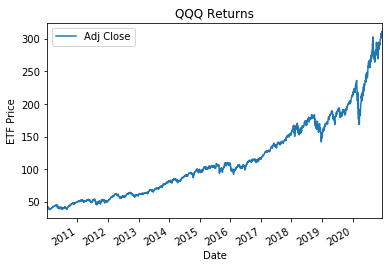

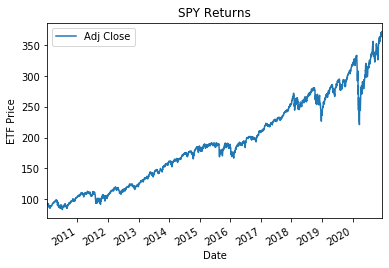

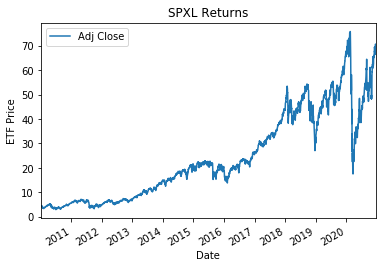

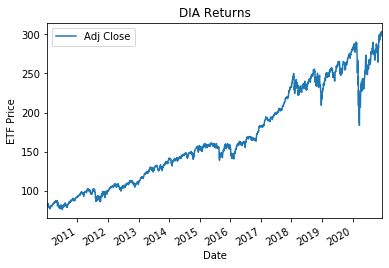

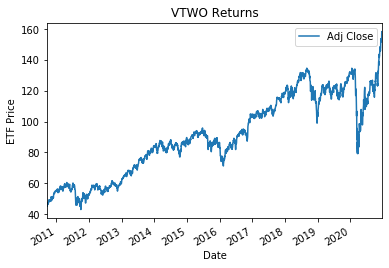

In [1]:
import pandas as pd #to deal with the data from the yahoo finance api
import numpy as np #for tensorflow and sklearn
import matplotlib.pyplot as plt #plotting
%matplotlib inline
import datetime as dt #datetime adjusting
import pandas_datareader.data as web #api for tick price / macroeconomic data
import warnings
warnings.filterwarnings('ignore') #ignore warnings

indices = ['QQQ','SPY','SPXL','DIA','VTWO']
for index in indices:
    df = web.DataReader(index,'yahoo','2010-01-01',dt.datetime.now())[['Adj Close']]
    df.plot()
    plt.title(f'{index} Returns')
    plt.ylabel('ETF Price')
    plt.show()

# Correlation Matrix

In [2]:
df = web.DataReader('^GSPC','yahoo','2010-01-01',dt.datetime.now())[['Adj Close']]
symbols_list = 'T10YIE','T5YIFR','DBAA','TEDRATE','MORTGAGE15US','OBMMIJUMBO30YF'
symbols = [] 
for ticker in symbols_list: 
    try: 
        r = web.DataReader(ticker,'fred','2010-01-01',dt.datetime.now()) 
        r[f'{ticker}'] = r[f'{ticker}'] 
        r1 = r[[f'{ticker}']].rolling(window=3).mean() 
        symbols.append(r1) 
    except:
        msg = 'Failed to read symbol: {0!r}, replacing with NaN.'
data = pd.concat(symbols, sort=False, axis=1) 
data = data.fillna(method='ffill') 
data = data.dropna() 
df = pd.concat([data,df],axis=1).dropna()
df.corr()

,T10YIE,T5YIFR,DBAA,TEDRATE,MORTGAGE15US,OBMMIJUMBO30YF,Adj Close
T10YIE,1.000000,0.973511,0.534938,-0.160898,0.679238,0.678957,-0.269256
T5YIFR,0.973511,1.000000,0.626117,-0.076244,0.731260,0.739438,-0.365634
DBAA,0.534938,0.626117,1.000000,0.383511,0.906614,0.920200,-0.715767
TEDRATE,-0.160898,-0.076244,0.383511,1.000000,0.227172,0.254016,-0.449759
MORTGAGE15US,0.679238,0.731260,0.906614,0.227172,1.000000,0.975247,-0.524481
OBMMIJUMBO30YF,0.678957,0.739438,0.920200,0.254016,0.975247,1.000000,-0.634984
Adj Close,-0.269256,-0.365634,-0.715767,-0.449759,-0.524481,-0.634984,1.000000


# Feature Importance Linear Regression

In [3]:
from sklearn.linear_model import LinearRegression
X = df[df.columns] #features
del X['Adj Close'] #lose label from features
Y = df[['Adj Close']] #label
model = LinearRegression() #linear regression model
model.fit(X, Y) #fit to features and label
importance = model.coef_ #find coefficients 
for i in importance: #loop through coefficients
    sig = pd.DataFrame([X.columns,i]).T #create a dataframe and transpose
sig.rename(columns={0: 'Feature', 1: 'Score'}) #rename columns

,Feature,Score
0,T10YIE,140.611
1,T5YIFR,-154.228
2,DBAA,-500.507
3,TEDRATE,-213.145
4,MORTGAGE15US,1252.95
5,OBMMIJUMBO30YF,-1152.97


# Indice Price Prediction Neural Network

In [4]:
import tensorflow as tf #machine learning libraries used for data splitting and model creation
from tensorflow import keras #for the deep learning model at the end
from sklearn.preprocessing import MinMaxScaler #normalize data
from sklearn.preprocessing import StandardScaler #for binary neural network
from sklearn.model_selection import train_test_split #split data
from tensorflow.keras.models import Sequential, Model #deep learning sequential model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Concatenate #layers for deep learing 
from keras import optimizers #optimizer for deep learning model (will most likely end up being Adam)


def data(ticker,start,end):
    df = web.DataReader(ticker.upper(),'yahoo',start,end)[['Adj Close']] #just the adjusted close of all the indices
    df['sm3'] = df['Adj Close'].rolling(window=3).mean() #3 day moving average
    df['sm9'] = df['Adj Close'].rolling(window=9).mean() #9 day moving average
    symbols_list = ['T10YIE','T5YIFR','DBAA'] #10yr BE IR / 5yr, 5yr forward inflation exp. rate/5-year Baa Corporate Bond Yield
    symbols = [] #empty list to add to as loop progesses
    for ticker in symbols_list: #loop through the macro economic drivers
        try: #try clause
            r = web.DataReader(ticker,'fred',start,end) #fred database
            r[f'{ticker}'] = r[f'{ticker}'] #making sure the ticker is specified in the dataset so I can look at it if I have to 
            r1 = r[[f'{ticker}']].rolling(window=3).mean() #3 day moving average of each daily driver
            symbols.append(r1) #append all these to the symbols
        except:
            msg = 'Failed to read symbol: {0!r}, replacing with NaN.'
    data = pd.concat(symbols, sort=False, axis=1) 
    data = data.fillna(method='ffill') #forward fill if any macro event isn't updated yet (usually updated at end of day)
    data = data.dropna() #drop any null values
    df = pd.concat([data,df],axis=1).dropna() #combine index data to macro data
    df['Target'] = df['Adj Close'].shift(-1) #shift adj close back 1: we are forecasting one day into the future
    df = df.drop(['Adj Close'],axis =1) #drop adj close because we are predicting for that but in the future
    return df.dropna() #no null values

def predict(df,pred_df):
    X = df[df.columns] #features
    del X['Target'] #don't want target variable apart of features
    Y = df[['Target']] #label data as the target
    x_train,x_test,y_train,y_test = train_test_split(X,Y,random_state=50,test_size=0.2) #training and testing
    x_val,x_test,y_val,y_test = train_test_split(x_test,y_test,random_state=50,test_size=0.5) #test and validation
    model = Sequential() #basic sequential model 
    model.add(Dense(50, input_dim=x_train.shape[1], #need the input shape of the data in tensorflow 2x
                        activation=tf.nn.leaky_relu, #was better than relu
                        kernel_initializer='he_normal')) #initializer to stop from vanishing/exploding gradient
    model.add(Dense(25, input_dim=50, #50 units in the first hidden layer
                    activation=tf.nn.leaky_relu,
                    kernel_initializer='he_normal'))
    model.add(Dense(1, activation=tf.nn.leaky_relu, #only one answer so you need one 'neuron'
                        kernel_initializer='he_normal'))
    model.compile(loss='mean_squared_error', #mse loss function
                      optimizer='adam', #adam optimizer
                      metrics=['mape']) #mean absolute percentage error metric to determine the performance of the model
    scaler = MinMaxScaler() #normalize the data since it is pretty different in terms of share price
    x_train_scaled = scaler.fit_transform(x_train) #apply the normalizer to the training features
    history = model.fit(x_train, y_train,  #fit the training data to the model
                        validation_data=(x_val, y_val), #validation data to better see how the model is doing
                        batch_size=32, #batch size of 32 seems pretty standard
                        epochs=9, #keeping epochs low for shortage of time
                        verbose=0) #I don't want to see all the epochs
    pred_features = pred_df.iloc[-1] #these will be in the pred_data function 
    prediction = model.predict(np.array([pred_features])) #need it in numpy array 
    mape = history.history['val_mape'] #getting the mean absolute percentage error to see which is the lowest
    mape = ["%.2f" % i for i in mape] #rounding it to two decimal places
    print(f"Validation Mean Absolute Percentage Error {mape}") #print statement to look cleaner once the code is run
    print(f'The predicted stock price for {ticker.upper()} tomorrow is ${round(float(prediction[0]),2)}.')
    if float(prediction[0])>float(df['Target'].iloc[-1:].values): #buy or sell statement based on model prediction and real time tick data
        print('Buy: ', round(float(prediction[0]),2), '>',round(float(df['Target'].iloc[-1:].values),2),
              '\nPCT DIFF: ',round((float(prediction[0]) - float(df['Target'].iloc[-1:].values))/float(df['Target'].iloc[-1:].values)*100,2),'%',)
    else:
        print('Sell: ', round(float(prediction[0]),2), '<',round(float(df['Target'].iloc[-1:].values),2),
              '\nPCT DIFF: ',round((float(prediction[0]) - float(df['Target'].iloc[-1:].values))/float(df['Target'].iloc[-1:].values)*100,2),'%')
    return mape

def pred_data(ticker,start,end):
    df = web.DataReader(ticker.upper(),'yahoo',start,end)[['Adj Close']] #query data of target security
    df['sm3'] = df['Adj Close'].rolling(window=3).mean() #moving averages (3 day)
    df['sm9'] = df['Adj Close'].rolling(window=9).mean() #moving averages (9 day)
    symbols_list = ['T10YIE','T5YIFR','DBAA'] #10yr BE IR / 5yr, 5yr forward inflation exp. rate/5-year Baa Corporate Bond Yield
    symbols = [] #empty list
    for ticker in symbols_list: #looping through each macroeconomic datapoint
        try:
            r = web.DataReader(ticker,'fred',start,end) #fred database
            r[f'{ticker}'] = r[f'{ticker}'] #worked this way, if I took this out the data wouldn't be collected 
            r1 = r[[f'{ticker}']].rolling(window=3).mean() #3 day moving average
            symbols.append(r1) #adding to the empty list
        except:
            msg = 'Failed to read symbol: {0!r}, replacing with NaN.' #fail message
    data = pd.concat(symbols, sort=False, axis=1) #combining all symbols into one dataframe
    data = data.fillna(method='ffill') #forward fill just in case you are running this before updated (updated daily)
    data = data.dropna() #drop null values
    df = pd.concat([data,df],axis=1).dropna() #combine and drop null
    df = df.drop(['Adj Close'],axis = 1) #drop adj close because it wasn't a feature
    return df.dropna() #return the dataframe with no null values

        
if __name__ == '__main__':
    tf.get_logger().setLevel('ERROR') #getting rid of tensorflow errors
    tickers = ['QQQ','SPY','^GSPC','SPXL','DJIA','^IXIC','^VIX','^RUT'] #popular stock market indices 
    for ticker in tickers: #looping through indices / etfs
        print(f'|||Index: {ticker}|||') #printing the stock that is being tested by the model
        try: #try clause just in case API doesn't have that ticker
            start = dt.datetime.now() - dt.timedelta(days=365*10) #10 year time frame
            end = dt.datetime.now() #today
            predict(data(ticker,start,end),pred_data(ticker,start,end)) #we want to predict the ind. indices
        except (IOError, KeyError): #error
            pass #keep running if an error is raised

Using TensorFlow backend.


|||Index: QQQ|||
Validation Mean Absolute Percentage Error ['2.21', '1.65', '1.45', '1.60', '2.37', '1.71', '1.37', '1.38', '1.75']
The predicted stock price for QQQ tomorrow is $307.24.
Sell:  307.24 < 311.0 
PCT DIFF:  -1.21 %
|||Index: SPY|||
Validation Mean Absolute Percentage Error ['1.06', '1.09', '1.64', '1.19', '0.92', '1.14', '0.94', '1.02', '1.18']
The predicted stock price for SPY tomorrow is $368.64.
Sell:  368.64 < 372.24 
PCT DIFF:  -0.97 %
|||Index: ^GSPC|||
Validation Mean Absolute Percentage Error ['2.01', '0.99', '0.94', '0.99', '0.94', '0.94', '0.94', '0.95', '0.98']
The predicted stock price for ^GSPC tomorrow is $3698.81.
Sell:  3698.81 < 3722.48 
PCT DIFF:  -0.64 %
|||Index: SPXL|||
Validation Mean Absolute Percentage Error ['6.99', '8.22', '6.45', '4.76', '4.04', '3.38', '3.16', '3.14', '3.11']
The predicted stock price for SPXL tomorrow is $70.96.
Buy:  70.96 > 70.61 
PCT DIFF:  0.49 %
|||Index: DJIA|||
Validation Mean Absolute Percentage Error ['1.49', '0.98', 

# Indice Binary Return Prediction Neural Network

In [5]:
def bin_data(ticker,start,end):
    df = web.DataReader(ticker.upper(),'yahoo',start,end)[['Adj Close']] 
    df['sm3'] = df['Adj Close'].rolling(window=3).mean() 
    df['sm9'] = df['Adj Close'].rolling(window=9).mean() 
    symbols_list = ['T10YIE','T5YIFR','DBAA'] #10yr BE IR / 5yr, 5yr forward inflation exp. rate/5-year Baa Corporate Bond Yield
    symbols = [] 
    for ticker in symbols_list: 
        try: 
            r = web.DataReader(ticker,'fred',start,end) 
            r[f'{ticker}'] = r[f'{ticker}'] 
            r1 = r[[f'{ticker}']].rolling(window=3).mean() 
            symbols.append(r1) 
        except:
            msg = 'Failed to read symbol: {0!r}, replacing with NaN.'
    data = pd.concat(symbols, sort=False, axis=1) 
    data = data.fillna(method='ffill') 
    data = data.dropna() 
    df = pd.concat([data,df],axis=1).dropna() 
    df['Daily Return'] = (df['Adj Close'].pct_change())*100 #daily return
    df['Target'] = int(False) #0 for a negative return
    df.loc[df['Daily Return'] > 0, 'Target']=int(True) #1 for a positive return
    df['Target'] = df['Target'].shift(-1) #shift it back one day for predicting
    df = df.drop(['Adj Close','Daily Return'],axis =1) #drop returns 
    return df.dropna() #no null values

def predict(df,pred_df):
    X = df[df.columns] 
    del X['Target'] 
    Y = df[['Target']] 
    x_train,x_test,y_train,y_test = train_test_split(X,Y,random_state=50,test_size=0.33) 
    x_val,x_test,y_val,y_test = train_test_split(x_test,y_test,random_state=50,test_size=0.5) 
    model = Sequential() 
    model.add(Dense(50, input_dim=x_train.shape[1], 
                        activation=tf.nn.leaky_relu)) 
    model.add(Dense(25, input_dim=50, 
                    activation=tf.nn.leaky_relu))
    model.add(Dense(1, activation='sigmoid')) #sigmoid function for binary classification problem
    model.compile(loss='binary_crossentropy', #binary crossentropy is a normally used loss for binary classification
                      optimizer='adam', #adam optimizer
                      metrics=['accuracy']) #binary accuracy to see how the model did
    scaler = StandardScaler() #standard scaler
    x_train_scaled = scaler.fit_transform(x_train) #apply scaler to training features
    history = model.fit(x_train, y_train,  #fit the training data to the model
                        validation_data=(x_val, y_val), #validation data to better see how the model is doing
                        batch_size=32, #batch size of 32 seems pretty standard
                        epochs=5, #keeping epochs low for shortage of time
                        verbose=0) #I don't want to see all the epochs
    pred_features = pred_df.iloc[-1] 
    prediction = model.predict(np.array([pred_features])) 
    acc = history.history['val_accuracy'] #getting the validation data accuracy
    acc = ["%.2f" % i for i in acc]
    print(f"Validation Accuracy {acc}") 
    
def bin_pred_data(ticker,start,end):
    df = web.DataReader(ticker.upper(),'yahoo',start,end)[['Adj Close']] 
    df['sm3'] = df['Adj Close'].rolling(window=3).mean() 
    df['sm9'] = df['Adj Close'].rolling(window=9).mean() 
    symbols_list = ['T10YIE','T5YIFR','DBAA'] #10yr BE IR / 5yr, 5yr forward inflation exp. rate/5-year Baa Corporate Bond Yield
    symbols = [] 
    for ticker in symbols_list: 
        try:
            r = web.DataReader(ticker,'fred',start,end) #fred database
            r[f'{ticker}'] = r[f'{ticker}']  
            r1 = r[[f'{ticker}']].rolling(window=9).mean() #9 day moving average
            symbols.append(r1) 
        except:
            msg = 'Failed to read symbol: {0!r}, replacing with NaN.' #fail message    
    data = pd.concat(symbols, sort=False, axis=1) 
    data = data.fillna(method='ffill') #forward fill if any macro event isn't updated yet (usually updated at end of day)
    data = data.dropna() 
    df = pd.concat([data,df],axis=1).dropna() #combine index data to macro data
    df = df.drop(['Adj Close'],axis =1) #drop adj close because we are predicting for that but in the future
    return df.dropna() #no null values
    
if __name__ == '__main__':
    tf.get_logger().setLevel('ERROR') #getting rid of tensorflow errors
    tickers = ['QQQ','SPY','^GSPC','SPXL','DJIA','^IXIC','^VIX','^RUT'] #popular stock market indices 
    for ticker in tickers: #looping through indices / etfs
        print(f'|||Index: {ticker}|||') #printing the stock that is being tested by the model
        try: #try clause just in case API doesn't have that ticker
            start = dt.datetime.now() - dt.timedelta(days=365*10) #10 year time frame
            end = dt.datetime.now() #today
            predict(bin_data(ticker,start,end),bin_pred_data(ticker,start,end)) #we want to predict the ind. indices
        except (IOError, KeyError): #error
            pass #keep running if an error is raised

|||Index: QQQ|||
Validation Accuracy ['0.43', '0.59', '0.59', '0.59', '0.59']
|||Index: SPY|||
Validation Accuracy ['0.57', '0.56', '0.43', '0.43', '0.57']
|||Index: ^GSPC|||
Validation Accuracy ['0.57', '0.56', '0.56', '0.58', '0.57']
|||Index: SPXL|||
Validation Accuracy ['0.56', '0.56', '0.54', '0.56', '0.56']
|||Index: DJIA|||
Validation Accuracy ['0.55', '0.55', '0.55', '0.45', '0.55']
|||Index: ^IXIC|||
Validation Accuracy ['0.54', '0.59', '0.46', '0.40', '0.41']
|||Index: ^VIX|||
Validation Accuracy ['0.54', '0.55', '0.54', '0.54', '0.46']
|||Index: ^RUT|||
Validation Accuracy ['0.52', '0.54', '0.49', '0.51', '0.55']
